# GHSOM Model Benchmarking

This notebook benchmarks GHSOM model training performance using synthetic data with three different preprocessing approaches:
1. **Raw Data**: Original high-dimensional synthetic data
2. **PCA-processed Data**: Dimensionality reduction using Principal Component Analysis
3. **t-SNE-processed Data**: Dimensionality reduction using t-Distributed Stochastic Neighbor Embedding

## Benchmark Metrics
- Training time
- Validation time
- Inference time (Best Matching Unit finding)
- Memory usage
- CPU usage
- Model quality metrics (activation, dispersion, depth)

## Dependencies
- `ghsom-py`: GHSOM model training
- `ghsom-toolkits`: Evaluation and visualization

## 1. Setup and Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import os
from typing import Dict, List, Tuple
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# GHSOM imports
from ghsom import GHSOM
from ghsom.io import save_model, load_model
from ghsom.utils.helpers import find_best_matching_unit
from ghsom.evaluation.metrics import (
    mean_data_centroid_activation,
    dispersion_rate,
    get_ghsom_depth,
    get_max_neurons_in_child_map,
)

# GHSOM toolkits imports
from ghsom_toolkits.adapters import adapt_model, build_lookup_table
from ghsom_toolkits.plotting import (
    visualize_ghsom_hierarchy,
    plot_weight_heatmap,
    plot_umatrix,
    plot_activation_map
)
from ghsom_toolkits.core.parsing import get_ghsom_statistics

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Synthetic Data Generation

Generate synthetic data with multiple well-separated clusters to test GHSOM's hierarchical clustering capabilities.

In [3]:
def generate_synthetic_data(n_samples: int = 1000, n_features: int = 50, n_clusters: int = 5, noise_level: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic data with multiple clusters.
    
    Args:
        n_samples: Total number of samples
        n_features: Number of features per sample
        n_clusters: Number of distinct clusters
        noise_level: Standard deviation of Gaussian noise
    
    Returns:
        data: Generated data array (n_samples, n_features)
        labels: True cluster labels for validation
    """
    samples_per_cluster = n_samples // n_clusters
    data_list = []
    labels_list = []
    
    for i in range(n_clusters):
        # Create cluster center with random offset
        center = np.random.randn(n_features) * 5
        
        # Generate samples around center
        cluster_data = np.random.randn(samples_per_cluster, n_features) * noise_level + center
        
        data_list.append(cluster_data)
        labels_list.extend([i] * samples_per_cluster)
    
    data = np.vstack(data_list)
    labels = np.array(labels_list)
    
    # Shuffle data
    shuffle_idx = np.random.permutation(len(data))
    data = data[shuffle_idx]
    labels = labels[shuffle_idx]
    
    return data, labels

# Generate data
print("Generating synthetic data...")
n_samples = 1000
n_features = 50
n_clusters = 5

data_raw, true_labels = generate_synthetic_data(
    n_samples=n_samples,
    n_features=n_features,
    n_clusters=n_clusters,
    noise_level=0.5
)

print(f"Generated data shape: {data_raw.shape}")
print(f"Number of clusters: {n_clusters}")
print(f"Samples per cluster: ~{n_samples // n_clusters}")

# Split into train/test sets
train_size = int(0.8 * n_samples)
train_data_raw = data_raw[:train_size]
test_data_raw = data_raw[train_size:]
train_labels = true_labels[:train_size]
test_labels = true_labels[train_size:]

print(f"\nTrain set: {train_data_raw.shape}")
print(f"Test set: {test_data_raw.shape}")

Generating synthetic data...
Generated data shape: (1000, 50)
Number of clusters: 5
Samples per cluster: ~200

Train set: (800, 50)
Test set: (200, 50)


## 3. Data Preprocessing

Apply PCA and t-SNE for dimensionality reduction to compare GHSOM performance on different representations.

In [6]:
def apply_pca(train_data: np.ndarray, test_data: np.ndarray, n_components: int = 20) -> Tuple[np.ndarray, np.ndarray]:
    """
    Apply PCA dimensionality reduction.
    
    Args:
        train_data: Training data
        test_data: Test data
        n_components: Number of principal components
    
    Returns:
        train_transformed: PCA-transformed training data
        test_transformed: PCA-transformed test data
    """
    # Standardize data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    
    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    train_transformed = pca.fit_transform(train_scaled)
    test_transformed = pca.transform(test_scaled)
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"PCA explained variance: {explained_variance:.2%}")
    
    return train_transformed, test_transformed

def apply_tsne(train_data: np.ndarray, test_data: np.ndarray, n_components: int = 20) -> Tuple[np.ndarray, np.ndarray]:
    """
    Apply t-SNE dimensionality reduction.
    
    Args:
        train_data: Training data
        test_data: Test data
        n_components: Desired number of t-SNE components (capped at 3)
    
    Returns:
        train_transformed: t-SNE-transformed training data
        test_transformed: t-SNE-transformed test data (approximated)
    """
    # Standardize data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    
    effective_components = min(n_components, 3)
    if n_components > 3:
        print(f"t-SNE supports up to 3 components; using {effective_components}")
    
    # Apply t-SNE to training data
    tsne = TSNE(
        n_components=effective_components,
        random_state=42,
        verbose=0,
        init="pca",
        learning_rate="auto",
)
    train_transformed = tsne.fit_transform(train_scaled)
    
    # For test data, use PCA projection to match output dimensionality
    pca_fallback = PCA(n_components=effective_components, random_state=42)
    pca_fallback.fit(train_scaled)
    test_transformed = pca_fallback.transform(test_scaled)
    
    print(f"t-SNE transformation completed (test set uses PCA projection)")
    
    return train_transformed, test_transformed

# Apply preprocessing
print("Applying PCA...")
train_data_pca, test_data_pca = apply_pca(train_data_raw, test_data_raw, n_components=20)
print(f"PCA-transformed shape: {train_data_pca.shape}\n")

print("Applying t-SNE...")
train_data_tsne, test_data_tsne = apply_tsne(train_data_raw, test_data_raw, n_components=20)
print(f"t-SNE-transformed shape: {train_data_tsne.shape}")

Applying PCA...
PCA explained variance: 99.33%
PCA-transformed shape: (800, 20)

Applying t-SNE...
t-SNE supports up to 3 components; using 3
t-SNE transformation completed (test set uses PCA projection)
t-SNE-transformed shape: (800, 3)
t-SNE transformation completed (test set uses PCA projection)
t-SNE-transformed shape: (800, 3)


## 4. Benchmark Infrastructure

Setup utilities for tracking time and resource usage during model training.

In [11]:
@dataclass
class BenchmarkResults:
    """Store benchmark results for a single model."""
    preprocessing_type: str
    data_shape: Tuple[int, int]
    
    # Training metrics
    training_time: float
    memory_usage_mb: float
    cpu_percent: float
    
    # Validation metrics
    validation_time: float
    
    # Inference metrics
    inference_time_mean: float
    inference_time_std: float
    
    # Model quality metrics
    activation_metric: float
    activation_metric_std: float
    dispersion_metric: float
    depth_metric: int
    breadth_metric: int
    num_nodes: int
    
    # Model object
    model: any = None

class ResourceMonitor:
    """Monitor CPU and memory usage."""
    
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.start_memory = 0
        self.peak_memory = 0
        self.cpu_samples = []
    
    def start(self):
        """Start monitoring."""
        self.start_memory = self.process.memory_info().rss / 1024 / 1024  # MB
        self.peak_memory = self.start_memory
        self.cpu_samples = []
    
    def sample(self):
        """Take a sample of current resource usage."""
        current_memory = self.process.memory_info().rss / 1024 / 1024  # MB
        self.peak_memory = max(self.peak_memory, current_memory)
        self.cpu_samples.append(self.process.cpu_percent(interval=0.1))
    
    def get_stats(self) -> Dict[str, float]:
        """Get resource usage statistics."""
        memory_used = self.peak_memory - self.start_memory
        avg_cpu = np.mean(self.cpu_samples) if self.cpu_samples else 0
        
        return {
            'memory_mb': memory_used,
            'cpu_percent': avg_cpu
        }

def benchmark_inference(model, test_data: np.ndarray, n_samples: int = 100) -> Tuple[float, float]:
    """
    Benchmark inference time (Best Matching Unit finding).
    
    Args:
        model: Trained GHSOM model
        test_data: Test data for inference
        n_samples: Number of samples to test
    
    Returns:
        mean_time: Mean inference time per sample
        std_time: Standard deviation of inference time
    """
    sample_indices = np.random.choice(len(test_data), size=min(n_samples, len(test_data)), replace=False)
    inference_times = []
    
    for idx in sample_indices:
        sample = test_data[idx]
        
        start_time = time.time()
        # Find BMU in the hierarchy
        _ = find_best_matching_unit(model, sample)
        end_time = time.time()
        
        inference_times.append(end_time - start_time)
    
    return np.mean(inference_times), np.std(inference_times)

print("Benchmark infrastructure ready!")

Benchmark infrastructure ready!


## 5. GHSOM Training and Benchmarking

Train GHSOM models on raw, PCA-processed, and t-SNE-processed data while tracking performance metrics.

In [12]:
def train_and_benchmark_ghsom(
    train_data: np.ndarray,
    test_data: np.ndarray,
    preprocessing_type: str,
    t1: float = 0.5,
    t2: float = 0.05,
    epochs: int = 20,
    n_workers: int = -1
) -> BenchmarkResults:
    """
    Train GHSOM model and collect benchmark metrics.
    
    Args:
        train_data: Training data
        test_data: Test data for validation
        preprocessing_type: Type of preprocessing applied
        t1: Growth threshold
        t2: Stopping criterion
        epochs: Number of training epochs
        n_workers: Number of parallel workers
    
    Returns:
        BenchmarkResults object containing all metrics
    """
    print(f"\n{'='*60}")
    print(f"Training GHSOM on {preprocessing_type} data")
    print(f"{'='*60}")
    print(f"Data shape: {train_data.shape}")
    print(f"Parameters: t1={t1}, t2={t2}, epochs={epochs}")
    
    # Initialize GHSOM
    ghsom = GHSOM(
        input_dataset=train_data,
        t1=t1,
        t2=t2,
        learning_rate=0.1,
        decay=0.9,
        gaussian_sigma=1.0
)
    
    # Training with resource monitoring
    monitor = ResourceMonitor()
    monitor.start()
    
    print("\nStarting training...")
    start_time = time.time()
    
    # Train model
    model = ghsom.train(epochs_number=epochs, n_workers=n_workers)
    
    # Sample resources during/after training
    monitor.sample()
    
    training_time = time.time() - start_time
    resource_stats = monitor.get_stats()
    
    print(f"Training completed in {training_time:.2f} seconds")
    print(f"Memory used: {resource_stats['memory_mb']:.2f} MB")
    print(f"Average CPU: {resource_stats['cpu_percent']:.1f}%")
    
    # Validation timing
    print("\nRunning validation...")
    val_start = time.time()
    for sample in test_data[:100]:  # Validate on 100 samples
        _ = find_best_matching_unit(model, sample)
    validation_time = time.time() - val_start
    print(f"Validation time: {validation_time:.2f} seconds")
    
    # Inference benchmarking
    print("\nBenchmarking inference...")
    inference_mean, inference_std = benchmark_inference(model, test_data, n_samples=100)
    print(f"Inference time: {inference_mean*1000:.3f} ± {inference_std*1000:.3f} ms per sample")
    
    # Calculate model quality metrics
    print("\nCalculating quality metrics...")
    activation_mean, activation_std = mean_data_centroid_activation(model, train_data)
    dispersion = dispersion_rate(model, train_data)
    depth = get_ghsom_depth(model.child_map, level=0)
    breadth = get_max_neurons_in_child_map(model.child_map)
    
    # Count total nodes in hierarchy
    adapted_model = adapt_model(model)
    stats = get_ghsom_statistics(adapted_model)
    num_nodes = stats.get('total_nodes', 0)
    
    print(f"Activation metric (mean ± std): {activation_mean:.4f} ± {activation_std:.4f}")
    print(f"Dispersion metric: {dispersion:.4f}")
    print(f"Depth: {depth}")
    print(f"Breadth (max neurons): {breadth}")
    print(f"Total nodes: {num_nodes}")
    
    # Create benchmark results
    results = BenchmarkResults(
        preprocessing_type=preprocessing_type,
        data_shape=train_data.shape,
        training_time=training_time,
        memory_usage_mb=resource_stats['memory_mb'],
        cpu_percent=resource_stats['cpu_percent'],
        validation_time=validation_time,
        inference_time_mean=inference_mean,
        inference_time_std=inference_std,
        activation_metric=activation_mean,
        activation_metric_std=activation_std,
        dispersion_metric=dispersion,
        depth_metric=depth,
        breadth_metric=breadth,
        num_nodes=num_nodes,
        model=model
)
    
    return results

# Configure GHSOM parameters
ghsom_params = {
    't1': 0.5,
    't2': 0.05,
    'epochs': 20,
    'n_workers': -1  # Use all available cores
}

print("GHSOM training function ready!")
print(f"\nTraining parameters: {ghsom_params}")

GHSOM training function ready!

Training parameters: {'t1': 0.5, 't2': 0.05, 'epochs': 20, 'n_workers': -1}


In [13]:
# Train models on different data representations
benchmark_results = {}

# 1. Raw data
benchmark_results['raw'] = train_and_benchmark_ghsom(
    train_data_raw,
    test_data_raw,
    preprocessing_type="Raw Data",
    **ghsom_params
)


Training GHSOM on Raw Data data
Data shape: (800, 50)
Parameters: t1=0.5, t2=0.05, epochs=20

Starting training...
Training completed in 0.38 seconds
Memory used: 2.28 MB
Average CPU: 0.0%

Running validation...
Validation time: 0.01 seconds

Benchmarking inference...
Inference time: 0.041 ± 0.016 ms per sample

Calculating quality metrics...
Activation metric (mean ± std): 3.5204 ± 0.3525
Dispersion metric: 1.6000
Depth: 1
Breadth (max neurons): 4
Total nodes: 2
Training completed in 0.38 seconds
Memory used: 2.28 MB
Average CPU: 0.0%

Running validation...
Validation time: 0.01 seconds

Benchmarking inference...
Inference time: 0.041 ± 0.016 ms per sample

Calculating quality metrics...
Activation metric (mean ± std): 3.5204 ± 0.3525
Dispersion metric: 1.6000
Depth: 1
Breadth (max neurons): 4
Total nodes: 2


In [14]:
# 2. PCA-processed data
benchmark_results['pca'] = train_and_benchmark_ghsom(
    train_data_pca,
    test_data_pca,
    preprocessing_type="PCA-processed",
    **ghsom_params
)


Training GHSOM on PCA-processed data
Data shape: (800, 20)
Parameters: t1=0.5, t2=0.05, epochs=20

Starting training...
Training completed in 0.43 seconds
Memory used: 0.06 MB
Average CPU: 0.0%

Running validation...
Validation time: 0.00 seconds

Benchmarking inference...
Inference time: 0.037 ± 0.008 ms per sample

Calculating quality metrics...
Activation metric (mean ± std): 0.7614 ± 0.1328
Dispersion metric: 1.6000
Depth: 1
Breadth (max neurons): 4
Total nodes: 2
Training completed in 0.43 seconds
Memory used: 0.06 MB
Average CPU: 0.0%

Running validation...
Validation time: 0.00 seconds

Benchmarking inference...
Inference time: 0.037 ± 0.008 ms per sample

Calculating quality metrics...
Activation metric (mean ± std): 0.7614 ± 0.1328
Dispersion metric: 1.6000
Depth: 1
Breadth (max neurons): 4
Total nodes: 2


In [15]:
# 3. t-SNE-processed data
benchmark_results['tsne'] = train_and_benchmark_ghsom(
    train_data_tsne,
    test_data_tsne,
    preprocessing_type="t-SNE-processed",
    **ghsom_params
)


Training GHSOM on t-SNE-processed data
Data shape: (800, 3)
Parameters: t1=0.5, t2=0.05, epochs=20

Starting training...
Training completed in 0.39 seconds
Memory used: 0.00 MB
Average CPU: 0.0%

Running validation...
Validation time: 0.01 seconds

Benchmarking inference...
Inference time: 0.045 ± 0.017 ms per sample

Calculating quality metrics...
Activation metric (mean ± std): 6.1634 ± 2.2388
Dispersion metric: 1.2500
Depth: 1
Breadth (max neurons): 4
Total nodes: 5
Training completed in 0.39 seconds
Memory used: 0.00 MB
Average CPU: 0.0%

Running validation...
Validation time: 0.01 seconds

Benchmarking inference...
Inference time: 0.045 ± 0.017 ms per sample

Calculating quality metrics...
Activation metric (mean ± std): 6.1634 ± 2.2388
Dispersion metric: 1.2500
Depth: 1
Breadth (max neurons): 4
Total nodes: 5


## 6. Results Analysis and Comparison

Create comprehensive comparison tables and visualizations.

In [16]:
# Create comparison dataframe
comparison_data = []

for key, results in benchmark_results.items():
    comparison_data.append({
        'Preprocessing': results.preprocessing_type,
        'Data Shape': f"{results.data_shape[0]}×{results.data_shape[1]}",
        'Training Time (s)': f"{results.training_time:.2f}",
        'Validation Time (s)': f"{results.validation_time:.2f}",
        'Inference Time (ms)': f"{results.inference_time_mean*1000:.3f} ± {results.inference_time_std*1000:.3f}",
        'Memory Usage (MB)': f"{results.memory_usage_mb:.2f}",
        'CPU Usage (%)': f"{results.cpu_percent:.1f}",
        'Activation (mean ± std)': f"{results.activation_metric:.4f} ± {results.activation_metric_std:.4f}",
        'Dispersion': f"{results.dispersion_metric:.4f}",
        'Depth': results.depth_metric,
        'Breadth': results.breadth_metric,
        'Total Nodes': results.num_nodes
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("BENCHMARK COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


BENCHMARK COMPARISON TABLE
  Preprocessing Data Shape Training Time (s) Validation Time (s) Inference Time (ms) Memory Usage (MB) CPU Usage (%) Activation (mean ± std) Dispersion  Depth  Breadth  Total Nodes
       Raw Data     800×50              0.38                0.01       0.041 ± 0.016              2.28           0.0         3.5204 ± 0.3525     1.6000      1        4            2
  PCA-processed     800×20              0.43                0.00       0.037 ± 0.008              0.06           0.0         0.7614 ± 0.1328     1.6000      1        4            2
t-SNE-processed      800×3              0.39                0.01       0.045 ± 0.017              0.00           0.0         6.1634 ± 2.2388     1.2500      1        4            5


### 6.1 Performance Metrics Visualization

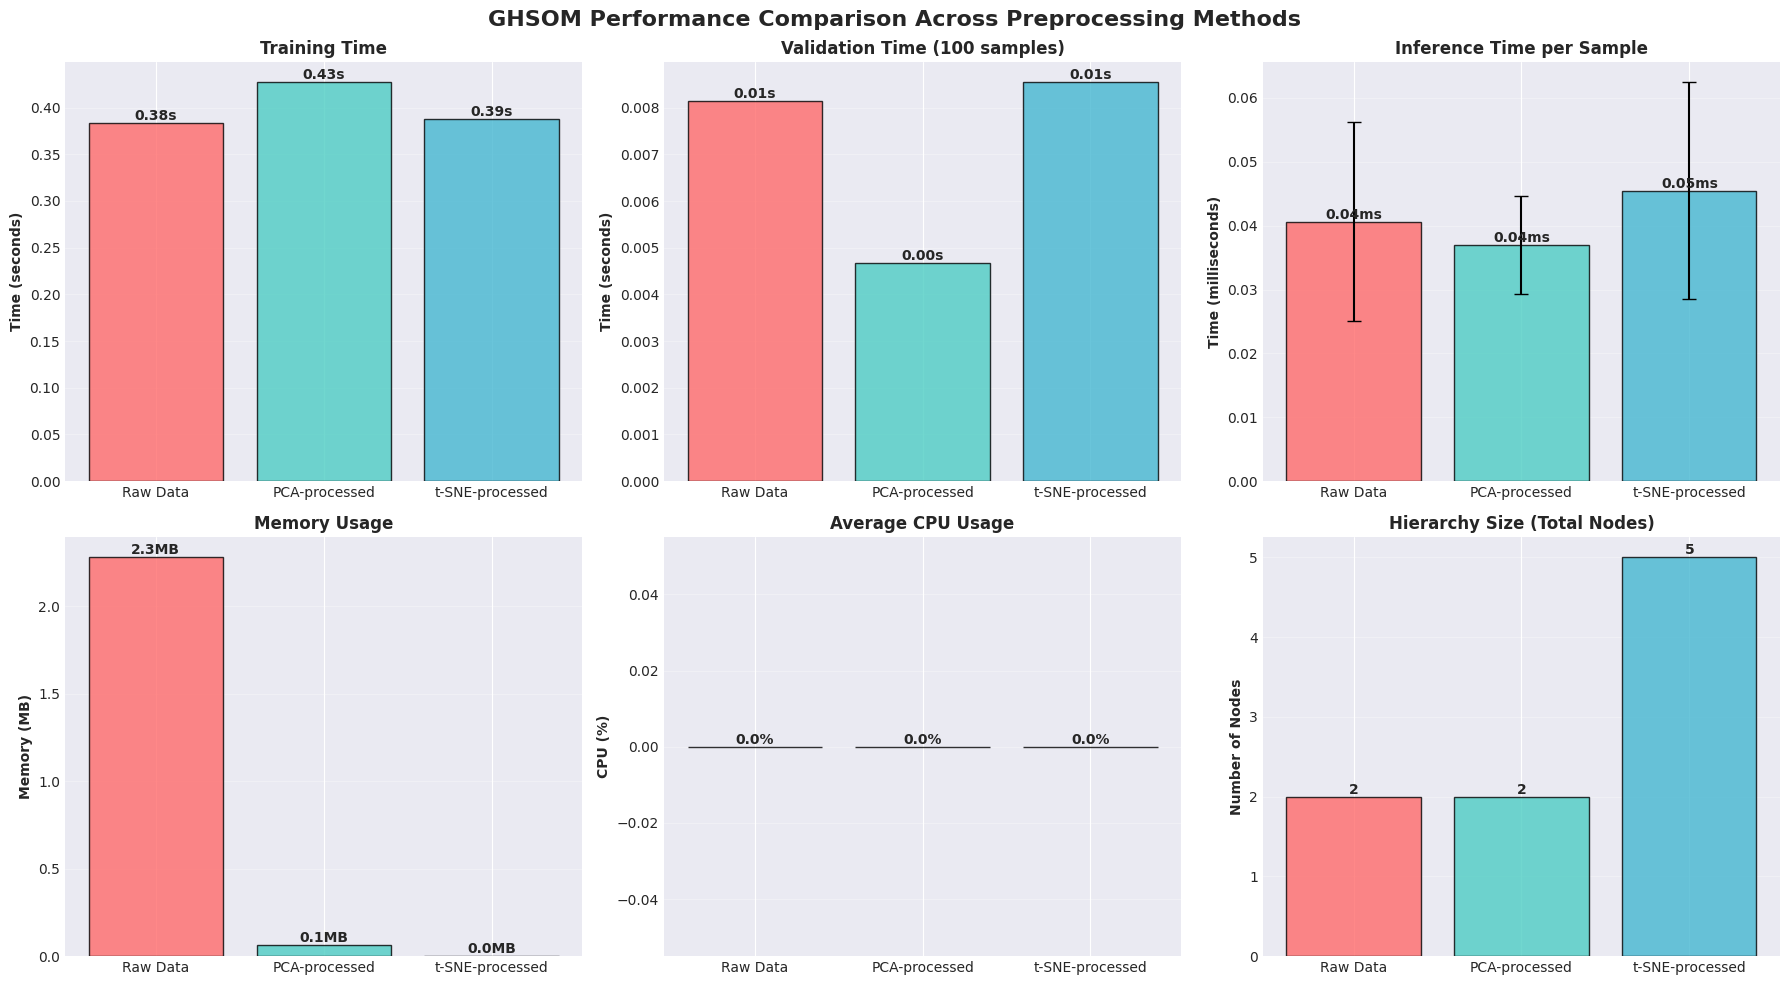


Performance comparison plot saved as 'ghsom_benchmark_performance.png'


In [17]:
# Create performance comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GHSOM Performance Comparison Across Preprocessing Methods', fontsize=16, fontweight='bold')

preprocessing_types = [r.preprocessing_type for r in benchmark_results.values()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. Training Time
ax = axes[0, 0]
training_times = [r.training_time for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, training_times, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Time (seconds)', fontweight='bold')
ax.set_title('Training Time', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, training_times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}s', ha='center', va='bottom', fontweight='bold')

# 2. Validation Time
ax = axes[0, 1]
validation_times = [r.validation_time for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, validation_times, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Time (seconds)', fontweight='bold')
ax.set_title('Validation Time (100 samples)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, validation_times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}s', ha='center', va='bottom', fontweight='bold')

# 3. Inference Time
ax = axes[0, 2]
inference_times = [r.inference_time_mean * 1000 for r in benchmark_results.values()]  # Convert to ms
inference_stds = [r.inference_time_std * 1000 for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, inference_times, yerr=inference_stds, 
              color=colors, alpha=0.8, edgecolor='black', capsize=5)
ax.set_ylabel('Time (milliseconds)', fontweight='bold')
ax.set_title('Inference Time per Sample', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, inference_times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}ms', ha='center', va='bottom', fontweight='bold')

# 4. Memory Usage
ax = axes[1, 0]
memory_usage = [r.memory_usage_mb for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, memory_usage, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Memory (MB)', fontweight='bold')
ax.set_title('Memory Usage', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, memory_usage):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}MB', ha='center', va='bottom', fontweight='bold')

# 5. CPU Usage
ax = axes[1, 1]
cpu_usage = [r.cpu_percent for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, cpu_usage, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('CPU (%)', fontweight='bold')
ax.set_title('Average CPU Usage', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, cpu_usage):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# 6. Total Nodes
ax = axes[1, 2]
total_nodes = [r.num_nodes for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, total_nodes, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Number of Nodes', fontweight='bold')
ax.set_title('Hierarchy Size (Total Nodes)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, total_nodes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('ghsom_benchmark_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPerformance comparison plot saved as 'ghsom_benchmark_performance.png'")

### 6.2 Model Quality Metrics Visualization

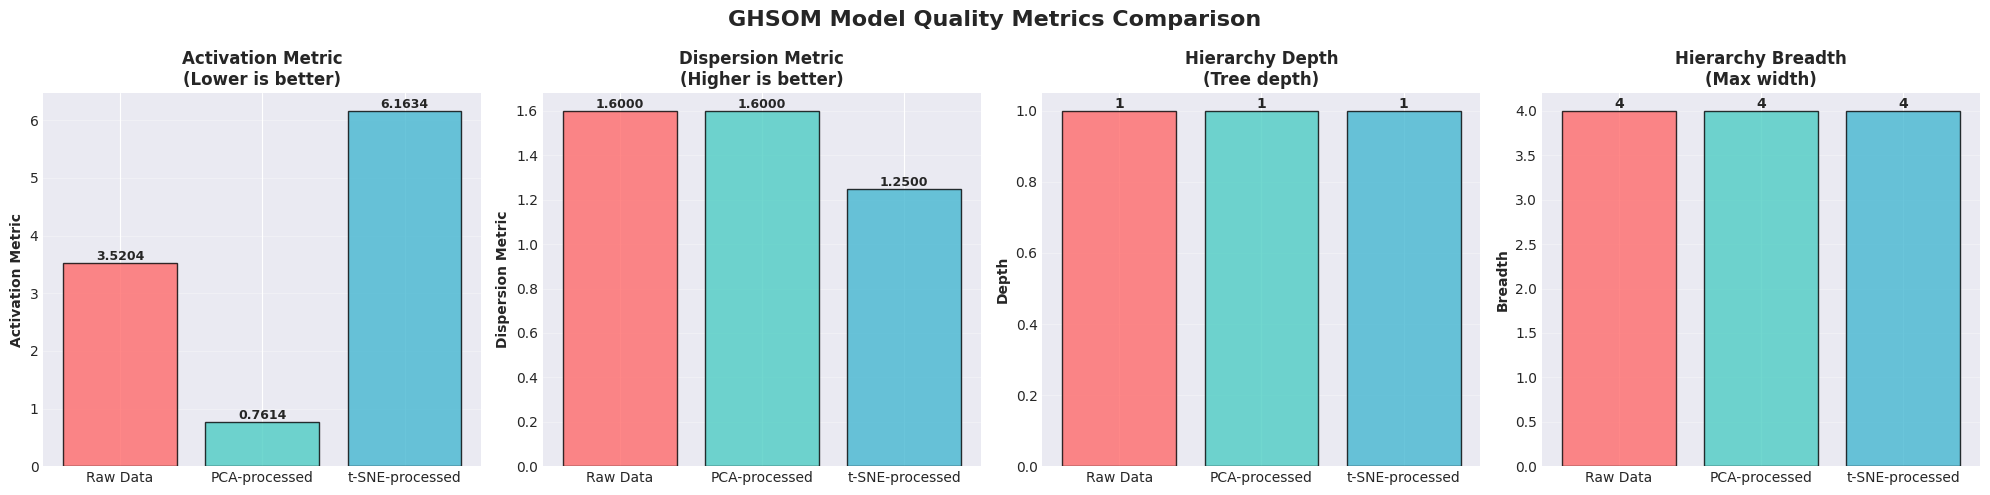


Quality metrics comparison plot saved as 'ghsom_benchmark_quality.png'


In [18]:
# Create quality metrics comparison plots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('GHSOM Model Quality Metrics Comparison', fontsize=16, fontweight='bold')

# 1. Activation Metric
ax = axes[0]
activation_values = [r.activation_metric for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, activation_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Activation Metric', fontweight='bold')
ax.set_title('Activation Metric\n(Lower is better)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, activation_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Dispersion Metric
ax = axes[1]
dispersion_values = [r.dispersion_metric for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, dispersion_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Dispersion Metric', fontweight='bold')
ax.set_title('Dispersion Metric\n(Higher is better)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, dispersion_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Hierarchy Depth
ax = axes[2]
depth_values = [r.depth_metric for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, depth_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Depth', fontweight='bold')
ax.set_title('Hierarchy Depth\n(Tree depth)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, depth_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom', fontweight='bold')

# 4. Hierarchy Breadth
ax = axes[3]
breadth_values = [r.breadth_metric for r in benchmark_results.values()]
bars = ax.bar(preprocessing_types, breadth_values, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Breadth', fontweight='bold')
ax.set_title('Hierarchy Breadth\n(Max width)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, breadth_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('ghsom_benchmark_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nQuality metrics comparison plot saved as 'ghsom_benchmark_quality.png'")

### 6.3 Radar Chart Comparison

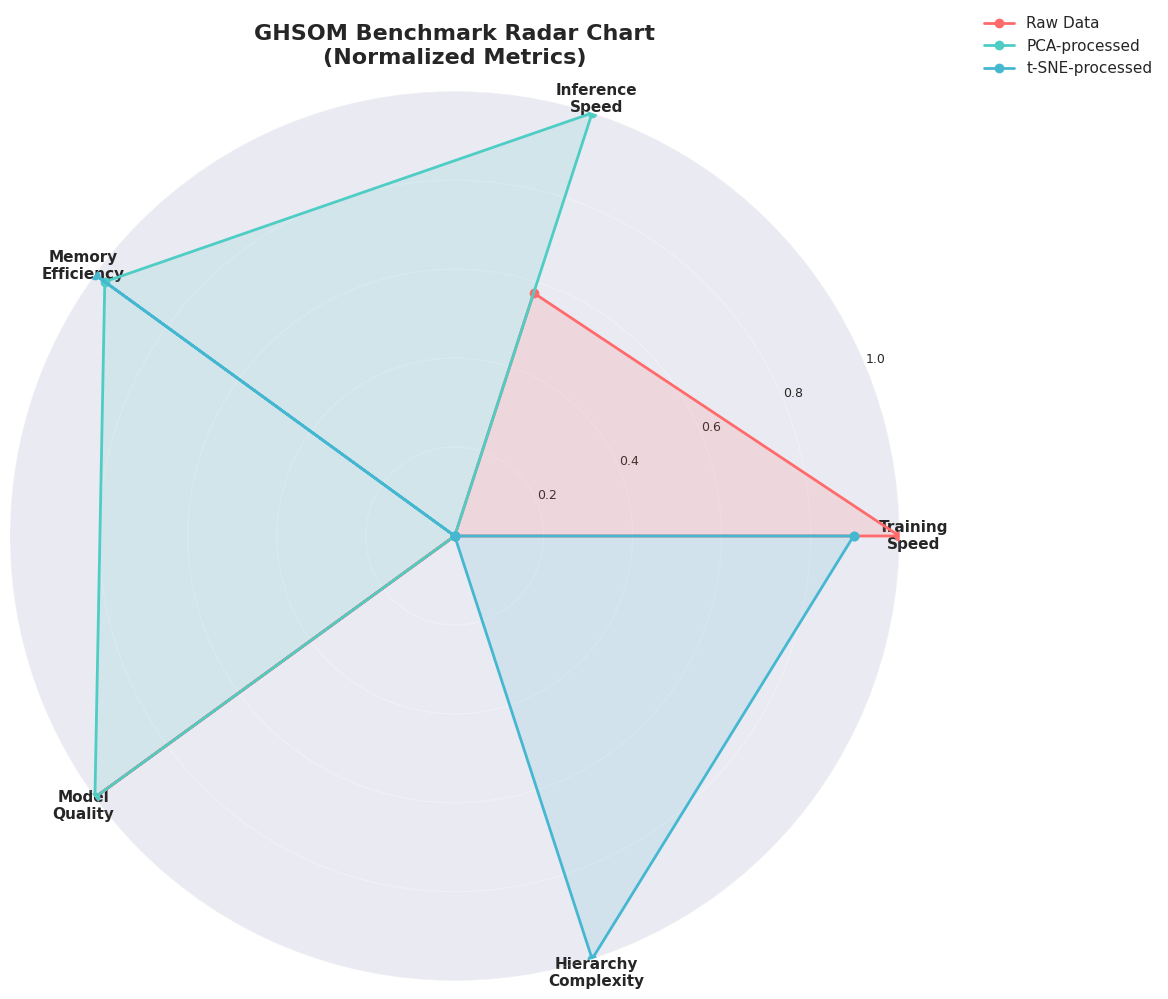


Radar chart saved as 'ghsom_benchmark_radar.png'


In [19]:
# Create radar chart for normalized comparison
from math import pi

# Normalize metrics to 0-1 scale for radar chart
def normalize_metric(values, inverse=False):
    """Normalize values to 0-1 range. If inverse=True, flip the scale."""
    min_val = min(values)
    max_val = max(values)
    if max_val == min_val:
        return [0.5] * len(values)
    normalized = [(v - min_val) / (max_val - min_val) for v in values]
    if inverse:
        normalized = [1 - v for v in normalized]
    return normalized

# Prepare radar chart data
categories = ['Training\nSpeed', 'Inference\nSpeed', 'Memory\nEfficiency', 
              'Model\nQuality', 'Hierarchy\nComplexity']
N = len(categories)

# Calculate composite scores (normalized)
training_speed = normalize_metric([r.training_time for r in benchmark_results.values()], inverse=True)
inference_speed = normalize_metric([r.inference_time_mean for r in benchmark_results.values()], inverse=True)
memory_efficiency = normalize_metric([r.memory_usage_mb for r in benchmark_results.values()], inverse=True)
model_quality = normalize_metric([r.dispersion_metric for r in benchmark_results.values()])  # Higher is better
hierarchy_complexity = normalize_metric([r.num_nodes for r in benchmark_results.values()])

# Create figure
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='polar')

# Compute angle for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot each preprocessing method
for idx, (key, results) in enumerate(benchmark_results.items()):
    values = [
        training_speed[idx],
        inference_speed[idx],
        memory_efficiency[idx],
        model_quality[idx],
        hierarchy_complexity[idx]
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=results.preprocessing_type, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

# Fix axis to go in the right order
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')

# Set y-axis limits
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.grid(True, alpha=0.3)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('GHSOM Benchmark Radar Chart\n(Normalized Metrics)', 
          size=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('ghsom_benchmark_radar.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRadar chart saved as 'ghsom_benchmark_radar.png'")

## 7. Model Visualization using ghsom-toolkits

Visualize the trained models using ghsom-toolkits for detailed analysis.

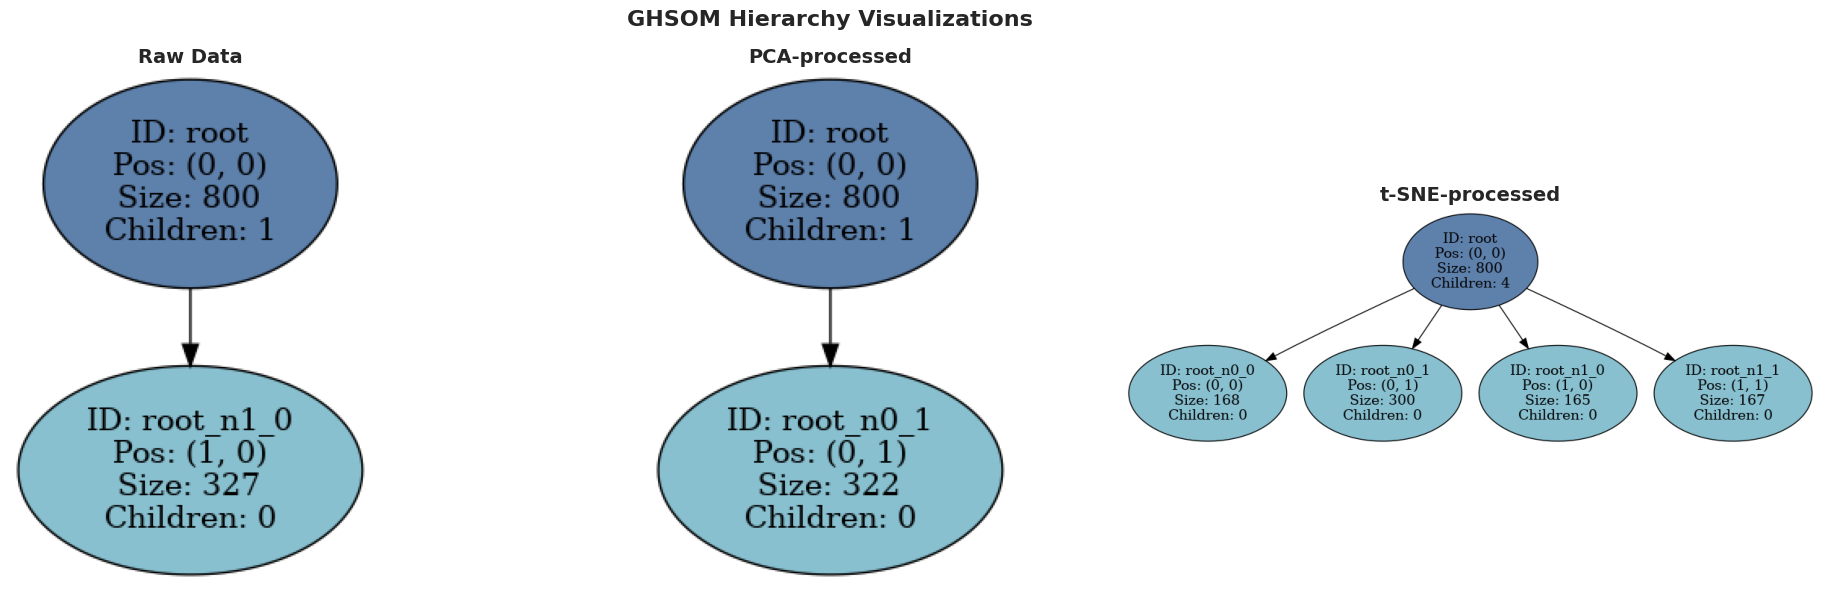


Hierarchy visualizations saved!


In [21]:
# Visualize hierarchies for each model
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('GHSOM Hierarchy Visualizations', fontsize=16, fontweight='bold')

for idx, (key, results) in enumerate(benchmark_results.items()):
    ax = axes[idx]
    
    # Adapt model for visualization
    adapted_model = adapt_model(results.model)
    lookup_table = build_lookup_table(adapted_model)
    
    # Save individual hierarchy visualization
    hierarchy_file = f'ghsom_hierarchy_{key}.png'
    visualize_ghsom_hierarchy(adapted_model, lookup_table, filename=hierarchy_file)
    
    # Display in subplot
    from PIL import Image
    img = Image.open(hierarchy_file)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(results.preprocessing_type, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('ghsom_hierarchies_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHierarchy visualizations saved!")

Generating U-Matrix visualizations...

Creating U-Matrix for Raw Data...
  Saved: ghsom_umatrix_raw.png
Creating U-Matrix for PCA-processed...
  Saved: ghsom_umatrix_raw.png
Creating U-Matrix for PCA-processed...
  Saved: ghsom_umatrix_pca.png
Creating U-Matrix for t-SNE-processed...
  Saved: ghsom_umatrix_pca.png
Creating U-Matrix for t-SNE-processed...
  Saved: ghsom_umatrix_tsne.png

U-Matrix visualizations completed!
  Saved: ghsom_umatrix_tsne.png

U-Matrix visualizations completed!


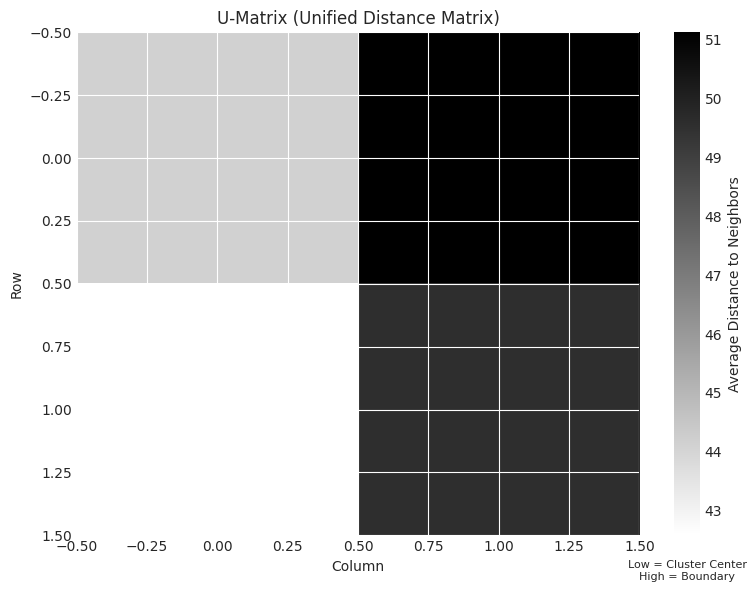

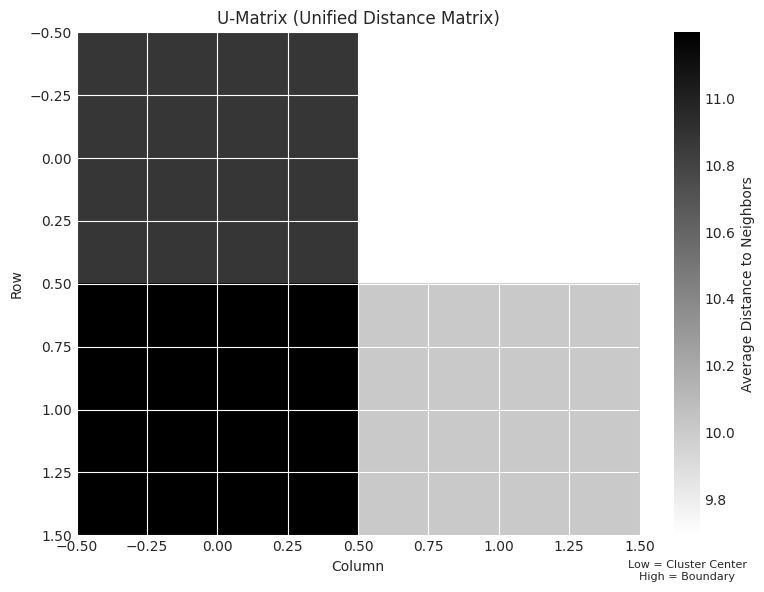

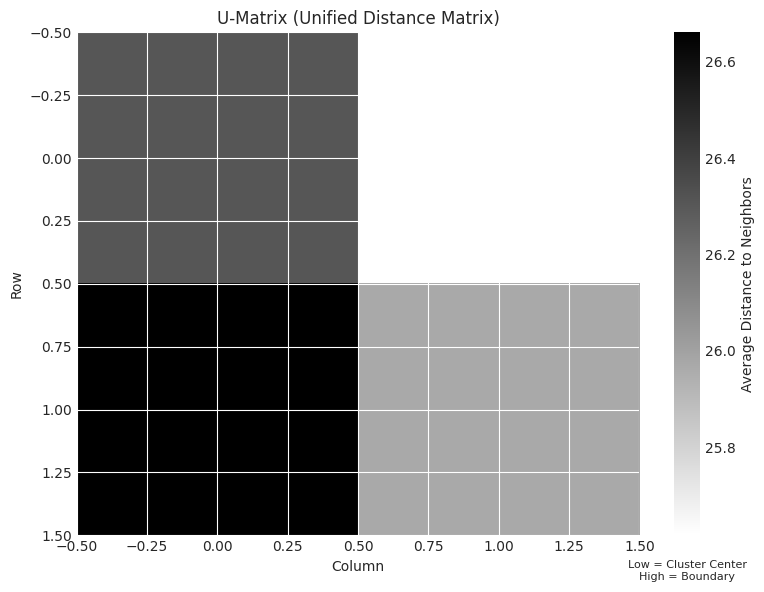

In [22]:
# Create U-Matrix visualizations
print("Generating U-Matrix visualizations...\n")

for key, results in benchmark_results.items():
    print(f"Creating U-Matrix for {results.preprocessing_type}...")
    
    # Adapt model
    adapted_model = adapt_model(results.model)
    
    # Generate U-Matrix
    umatrix_file = f'ghsom_umatrix_{key}.png'
    plot_umatrix(adapted_model, save_path=umatrix_file)
    
    print(f"  Saved: {umatrix_file}")

print("\nU-Matrix visualizations completed!")

## 8. Summary and Conclusions

In [23]:
print("\n" + "="*80)
print("BENCHMARK SUMMARY")
print("="*80)

print("\n1. PERFORMANCE SUMMARY")
print("-" * 80)

# Find best performer in each category
fastest_training = min(benchmark_results.items(), key=lambda x: x[1].training_time)
fastest_inference = min(benchmark_results.items(), key=lambda x: x[1].inference_time_mean)
most_memory_efficient = min(benchmark_results.items(), key=lambda x: x[1].memory_usage_mb)
best_quality = max(benchmark_results.items(), key=lambda x: x[1].dispersion_metric)

print(f"Fastest Training: {fastest_training[1].preprocessing_type} ({fastest_training[1].training_time:.2f}s)")
print(f"Fastest Inference: {fastest_inference[1].preprocessing_type} ({fastest_inference[1].inference_time_mean*1000:.3f}ms)")
print(f"Most Memory Efficient: {most_memory_efficient[1].preprocessing_type} ({most_memory_efficient[1].memory_usage_mb:.2f}MB)")
print(f"Best Model Quality: {best_quality[1].preprocessing_type} (dispersion: {best_quality[1].dispersion_metric:.4f})")

print("\n2. KEY FINDINGS")
print("-" * 80)

# Calculate relative improvements
raw_results = benchmark_results['raw']
pca_results = benchmark_results['pca']
tsne_results = benchmark_results['tsne']

pca_speedup = (raw_results.training_time / pca_results.training_time - 1) * 100
tsne_speedup = (raw_results.training_time / tsne_results.training_time - 1) * 100

print(f"• PCA preprocessing provides {pca_speedup:+.1f}% training time change compared to raw data")
print(f"• t-SNE preprocessing provides {tsne_speedup:+.1f}% training time change compared to raw data")
print(f"• Dimensionality reduction from {raw_results.data_shape[1]} to {pca_results.data_shape[1]} features")
print(f"• Raw data produced {raw_results.num_nodes} nodes vs PCA: {pca_results.num_nodes}, t-SNE: {tsne_results.num_nodes}")

print("\n3. RECOMMENDATIONS")
print("-" * 80)
print("• For fastest training: Use PCA preprocessing for high-dimensional data")
print("• For best model quality: Evaluate dispersion and activation metrics")
print("• For production deployment: Consider inference time and memory constraints")
print("• For interpretability: Raw data maintains original feature semantics")

print("\n" + "="*80)
print("BENCHMARK COMPLETED SUCCESSFULLY")
print("="*80)

# Save benchmark results to file
comparison_df.to_csv('ghsom_benchmark_results.csv', index=False)
print("\nResults saved to 'ghsom_benchmark_results.csv'")


BENCHMARK SUMMARY

1. PERFORMANCE SUMMARY
--------------------------------------------------------------------------------
Fastest Training: Raw Data (0.38s)
Fastest Inference: PCA-processed (0.037ms)
Most Memory Efficient: t-SNE-processed (0.00MB)
Best Model Quality: Raw Data (dispersion: 1.6000)

2. KEY FINDINGS
--------------------------------------------------------------------------------
• PCA preprocessing provides -10.1% training time change compared to raw data
• t-SNE preprocessing provides -1.1% training time change compared to raw data
• Dimensionality reduction from 50 to 20 features
• Raw data produced 2 nodes vs PCA: 2, t-SNE: 5

3. RECOMMENDATIONS
--------------------------------------------------------------------------------
• For fastest training: Use PCA preprocessing for high-dimensional data
• For best model quality: Evaluate dispersion and activation metrics
• For production deployment: Consider inference time and memory constraints
• For interpretability: Raw d

## 9. Export Results

In [24]:
# Save models for future use
print("Saving trained models...")

for key, results in benchmark_results.items():
    model_path = f'ghsom_model_{key}.pkl'
    save_model(results.model, model_path)
    print(f"  Saved: {model_path}")

print("\nAll models saved successfully!")

# Create a summary report
report = {
    'benchmark_date': pd.Timestamp.now().isoformat(),
    'data_info': {
        'n_samples': n_samples,
        'n_features_raw': n_features,
        'n_features_reduced': 20,
        'n_clusters': n_clusters
    },
    'ghsom_params': ghsom_params,
    'results': comparison_df.to_dict('records')
}

import json
with open('ghsom_benchmark_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\nBenchmark report saved to 'ghsom_benchmark_report.json'")

Saving trained models...
  Saved: ghsom_model_raw.pkl
  Saved: ghsom_model_pca.pkl
  Saved: ghsom_model_tsne.pkl

All models saved successfully!

Benchmark report saved to 'ghsom_benchmark_report.json'


## Conclusion

This notebook has successfully benchmarked GHSOM model training across three data preprocessing approaches:

1. **Raw Data**: Original high-dimensional data
2. **PCA-processed**: Dimensionality reduction maintaining maximum variance
3. **t-SNE-processed**: Non-linear dimensionality reduction for visualization

The comprehensive benchmarks include:
- ✅ Training time and resource usage
- ✅ Validation and inference performance
- ✅ Model quality metrics (activation, dispersion, depth, breadth)
- ✅ Hierarchical structure analysis
- ✅ Visual comparisons and exports

All results, models, and visualizations have been saved for further analysis.